# Data augmentation
Data generators in this project expect an transformation for data augmentation. Here is a example for 2D images

In [1]:
from skimage.data import astronaut
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import volumentations as V

## Image augmentation using `tensorflow`

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


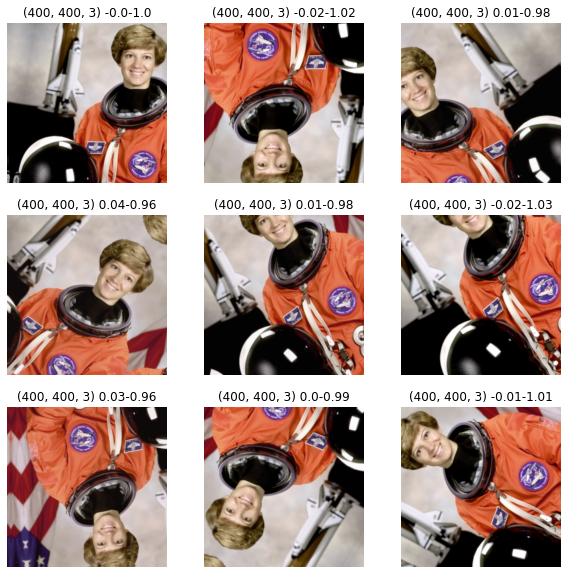

In [7]:
# https://www.tensorflow.org/tutorials/images/data_augmentation
img = astronaut()
print(img.shape)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # silence tf warnings

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(height_factor=0.1,
                                      width_factor=0.1,
                                      fill_mode="reflect",
                                      interpolation="bilinear",
                                      seed=None,
                                      fill_value=0.0),  # gives a bunch of converting warning
    tf.keras.layers.RandomRotation(factor=0.2,
                                   fill_mode="reflect",
                                   interpolation="bilinear",
                                   seed=None,
                                   fill_value=0.0),
    tf.keras.layers.RandomZoom(height_factor=0.1,
                               width_factor=None,
                               fill_mode="reflect",
                               interpolation="bilinear",
                               seed=None,
                               fill_value=0.0),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical",
                               seed=None),
    tf.keras.layers.RandomCrop(height=400,
                               width=400,
                               seed=None),
    tf.keras.layers.RandomContrast(factor=0.1,
                                   seed=None),
    tf.keras.layers.Rescaling(1./255)
])

# Add the image to a batch.
image = tf.cast(tf.expand_dims(img, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    np_img = augmented_image[0].numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape) + " " + str(round(np_img.min(), 2)) + "-" + str(round(np_img.max(), 2)))
    plt.axis("off")

(400, 400, 3)


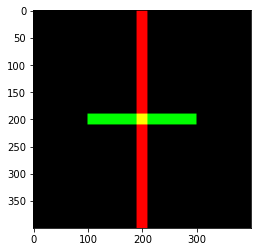

In [8]:
# simple annotation for validation
anno = np.zeros(augmented_image.shape[1:], dtype=np.uint8)
half_len = anno.shape[0]//2
anno[:, half_len-10:half_len+10, 0] = 255
anno[half_len-10:half_len+10, 100:-100, 1] = 255

print(anno.shape)
plt.imshow(anno)
plt.show()

# Add the annotation to a batch.
annotation = tf.cast(tf.expand_dims(anno, 0), tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


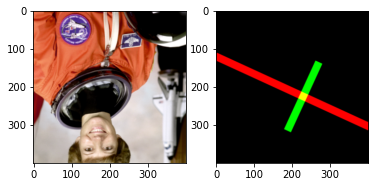

In [12]:
x = data_augmentation(image, training=True)[0]
y = data_augmentation(annotation)[0]

plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.show()

This preprocessing sequence can be added to a Keras model and will only be considered when fitting data (not during prediction)  
  
Now that's nice, but I can't be bothered to understand `tf.data.Dataset` data loading functions to be able to transform annotation as well.

## Image augmentation using `albumentations`
Python module for image augmentation which I'll be using for training since I know how to use it, it's fast and is similar to volumentations module which I'll use for volume augmentation.

In [13]:
img_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(p=0.2),
    A.Rotate(limit=60, interpolation=1, border_mode=4, value=None, mask_value=None, p=1),
    #A.RandomBrightnessContrast(p=0.2),
])

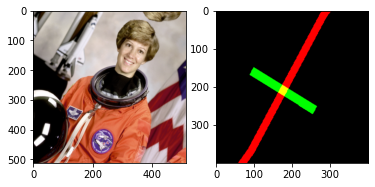

In [14]:
data = {'image': img,
        'mask': anno}
        
aug_data = img_transform(**data)
        
# fill batches
x, y = aug_data['image'], aug_data['mask']

plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.show()

## Volume augmentation using `volumentations`
Python module for volume augmentation, based of `albumentations` module

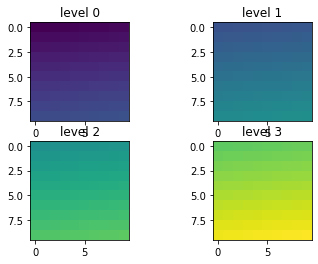

In [15]:
volume = np.arange(400).reshape((4,10,10))

def show_volume(x):
    plt.subplot(221)
    plt.imshow(x[0], vmin=0, vmax=400)
    plt.title('level 0')
    plt.subplot(222)
    plt.imshow(x[1], vmin=0, vmax=400)
    plt.title('level 1')
    plt.subplot(223)
    plt.imshow(x[2], vmin=0, vmax=400)
    plt.title('level 2')
    plt.subplot(224)
    plt.imshow(x[3], vmin=0, vmax=400)
    plt.title('level 3')
    plt.show()

show_volume(volume)

In [42]:
vol_transform = V.Compose([
    V.Flip(axis=1, p=0.5),
    V.Flip(axis=2, p=0.5),
    V.Rotate(x_limit=(-90,90), interpolation=3, border_mode='reflect', p=1),
])

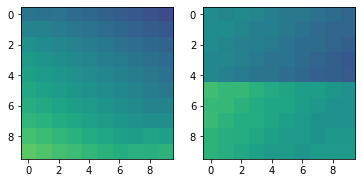

In [44]:
data = {'image': np.arange(400).reshape((4,10,10)),
        'mask': np.arange(400).reshape((4,10,10))}
        
aug_data = vol_transform(**data)
        
# fill batches
x, y = aug_data['image'], aug_data['mask']

plt.subplot(121)
plt.imshow(x[1], vmin=0, vmax=400)
plt.subplot(122)
plt.imshow(y[1], vmin=0, vmax=400)
plt.show()

I dont even know why I bother with this rn, skip until 3d